In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
data_train = pd.read_csv('D:/DW1/New folder/GEE/GEE/data/danrer11_chopchop_train.csv',index_col=0)
data_test = pd.read_csv('D:/DW1/New folder/GEE/GEE/data/danrer11_chopchop_test.csv',index_col=0)

In [3]:
data_train['GUIDE'].values

array(['CCGCGTAATGCTGGTTCTGCTGG', 'TGTGTTCACCCTGCGTCGAGTGG',
       'TTCACAATGTCTTCTAATGCAGG', ..., 'AGGGGTGATTGTGTAAAAGCAGG',
       'TAATAAAAATGACTTTAAAAAGG', 'GTTACTGTCGTGAGGGGGCGTGG'], dtype=object)

# Transform Data
## One-hot encoding

In [4]:
encoding = {'A':np.array([1,0,0,0]),
            'C':np.array([0,1,0,0]),
            'G':np.array([0,0,1,0]),
            'T':np.array([0,0,0,1])}

def one_hot(guide,encoding):
    data = np.zeros((4,len(guide)))
    assert data.shape == (4,23)
    for i in range(data.shape[-1]):
        data[:,i] = encoding[guide[i]]
    return data

#print(one_hot('CTGATCACGGCTGAAGGACTCGG',encoding))

def batch_one_hot(data,encoding):
    guides = np.zeros((len(data),4,23))
    i=0
    for guide in data['GUIDE']:
        guides[i] = one_hot(guide,encoding)
        i+=1
    return guides

guides_train = batch_one_hot(data_train,encoding)
guides_test = batch_one_hot(data_test,encoding)
print('Train dataset size:',guides_train.shape)
print('Test dataset size:',guides_test.shape)

Train dataset size: (226420, 4, 23)
Test dataset size: (56606, 4, 23)


In [5]:
print(one_hot('CTGATCACGGCTGAAGGACTCGG',encoding))

[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## `Pytorch` data format

In [6]:
class GGEDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample.float()
    
transform = transforms.Compose([
        transforms.ToTensor()
    ])
GGE_dataset_train = GGEDataset(data = guides_train, transform = transform)
GGE_dataset_test = GGEDataset(data = guides_test, transform = transform)

trainloader = torch.utils.data.DataLoader(GGE_dataset_train, batch_size=50000,shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(GGE_dataset_test, batch_size=50000,shuffle=False, num_workers=0)

In [7]:
len(GGE_dataset_train)
len(GGE_dataset_test)

56606

# Create Autoencoder

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(92, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 30)
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 60),
            nn.ReLU(),
            nn.Linear(60, 92),
            nn.Sigmoid()
        )
        
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.ConvTranspose2d(6, 1, 2)
        self.pool2 =nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        x = x.view(-1,1*4*23)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1,4,23)

        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
net = Autoencoder().to(device)

## Load model

In [11]:
checkpoint = torch.load('D:/DW1/New folder/GEE/GEE/model/autoencoder.pth.tar',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Train the linear model

## extract features

Transfer all the guide from 92 dimension to 30 dimension

In [12]:
trainloader = torch.utils.data.DataLoader(GGE_dataset_train, batch_size=len(GGE_dataset_train),shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(GGE_dataset_test, batch_size=len(GGE_dataset_test),shuffle=False, num_workers=0)

In [13]:
with torch.no_grad():
    for data in trainloader:
        tr_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')


In [14]:
with torch.no_grad():
    for data in testloader:
        test_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')

In [15]:
class GeneDataset(object):
    def __init__(self, guide, eff):
        self.target_sequence = guide
        self.efficiency = eff.values
    
    def __getitem__(self, idx):
        seq = self.target_sequence[idx]
        eff = torch.as_tensor(self.efficiency[idx], dtype=torch.float32)
        return seq, eff
    
    def __len__(self):
        return len(self.target_sequence)

In [16]:
train_size = int(0.8*len(tr_fea))
vali_size = len(tr_fea) - train_size

tr = GeneDataset(tr_fea[:train_size],data_train['EFFICIENCY']/100)
validation = GeneDataset(tr_fea[train_size:], data_train['EFFICIENCY']/100)
test = GeneDataset(test_fea,data_test['EFFICIENCY']/100)

# get dataloader

In [17]:
chop_trainloader = torch.utils.data.DataLoader(tr, batch_size=64,shuffle=True, num_workers=0)
chop_validloader = torch.utils.data.DataLoader(validation, batch_size=64,shuffle=True, num_workers=0)
chop_testloader = torch.utils.data.DataLoader(test, batch_size=64,shuffle=True, num_workers=0)

# construct model

In [18]:
# Pytorch线性回归

# 导入库
import torch      
from torch.autograd import Variable     
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")

# 创建LinearRegression类
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        # 超级函数，继承自nn.Module
        super(LinearRegression,self).__init__()
        # 线性函数
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.75)
        )      
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.75)
        )      
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.75)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.75)
        ) 
        self.layer5 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.75)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.75)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self,x):
        x = self.layer1(x);
        x = self.layer2(x);
        x = self.layer3(x);
        x = self.layer4(x);
        x = self.layer5(x);
        x = self.layer6(x);
        x = self.layer7(x);
        return x
    

In [19]:
#input_dim = tr[0][0].shape[0]
input_dim = tr[0][0].shape[0]
output_dim = 1

In [20]:
# 定义模型
input_dim = tr[0][0].shape[0]

output_dim = 1

#Linear Regression
#model = LinearRegression(input_dim,output_dim) # 输入和输出大小为1
#LSTM
model = LinearRegression(input_dim, output_dim)

# MSE/均方差
criterion = nn.MSELoss()

# 优化(找到最小化差值的参数)
learning_rate = 0.0001  # 学习率, 达到最佳参数的速度有多快
#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=0.0001)

In [21]:
def train(epoch, model, trainloader, validloader,tolerance=0.0001):
    valid_loss_his=[]
    train_loss_his=[]
    model.train()

    for e in range(epoch):
        train_loss = 0
        valid_loss = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to('cpu'), targets.to('cpu')
            outputs = model(inputs.view(inputs.shape[0],30))
            loss = criterion(outputs[:,0], targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)

        mean_loss = train_loss/(batch_idx+1)
        train_loss_his.append(mean_loss)
        model.eval()
        with torch.no_grad():
            for batch_idx, (valid, tar) in enumerate(validloader):
                valid, tar = valid.to('cpu'), tar.to('cpu')
                opt = model(valid.view(valid.shape[0],30))
                loss_2 = criterion(opt, tar)
                valid_loss += loss_2.item()*valid.size(0)
            mean_valid_loss = valid_loss/(batch_idx+1)
            valid_loss_his.append(mean_valid_loss)
        print('Train: Epoch: %d| train_loss: %f|valid_loss: %f'% (e, mean_loss, mean_valid_loss))
        
    return train_loss_his, valid_loss_his

In [22]:
train_loss_his, valid_loss_his = train(epoch=50, model=model, trainloader=chop_trainloader, validloader=chop_validloader)

Train: Epoch: 0| train_loss: 1.611397|valid_loss: 1.048258
Train: Epoch: 1| train_loss: 0.953535|valid_loss: 1.329936
Train: Epoch: 2| train_loss: 0.450304|valid_loss: 1.627991
Train: Epoch: 3| train_loss: 0.336516|valid_loss: 1.708515
Train: Epoch: 4| train_loss: 0.294196|valid_loss: 1.702361
Train: Epoch: 5| train_loss: 0.273434|valid_loss: 1.741056
Train: Epoch: 6| train_loss: 0.260105|valid_loss: 1.783802
Train: Epoch: 7| train_loss: 0.250303|valid_loss: 1.722392
Train: Epoch: 8| train_loss: 0.243134|valid_loss: 1.797742
Train: Epoch: 9| train_loss: 0.236582|valid_loss: 1.787264
Train: Epoch: 10| train_loss: 0.231213|valid_loss: 1.775551
Train: Epoch: 11| train_loss: 0.227882|valid_loss: 1.760367
Train: Epoch: 12| train_loss: 0.223470|valid_loss: 1.828082
Train: Epoch: 13| train_loss: 0.220583|valid_loss: 1.782933
Train: Epoch: 14| train_loss: 0.217405|valid_loss: 1.790956
Train: Epoch: 15| train_loss: 0.215983|valid_loss: 1.797386
Train: Epoch: 16| train_loss: 0.213668|valid_loss:

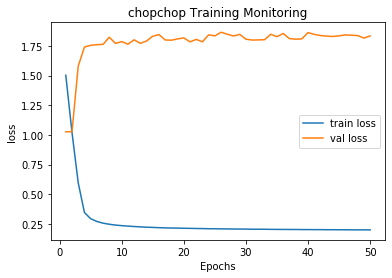

In [24]:
import matplotlib.pyplot as plt
x = list(range(1,len(train_loss_his)+1))

plt.plot(x,train_loss_his, label='train loss')
plt.plot(x,valid_loss_his, label='val loss')

plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('chopchop Training Monitoring')
plt.legend()
plt.show()

In [27]:
data_test

,GUIDE,EFFICIENCY,CHR,STRAND,TSS,LOCATION
229866,ATTAGTACGCGAACTCATAGCGG,55.34,5,-1,62340897,62340956
110483,ACTGCAGTCGCGATTGGAGGAGG,44.18,1,-1,49498262,49498344
13230,TCGGACAAGAAACTAGCTTTGGG,48.11,11,1,15875002,15874883
244662,CAGCGGAGAAGAGGAGGCCGTGG,48.86,7,1,13491501,13491645
222274,TAAATATGTAAAATATTTCAAGG,29.31,5,-1,32274383,32274243
...,...,...,...,...,...,...
232791,ACAGAGTTCCAGCAGAAGTCAGG,46.99,6,-1,10828881,10828852
196632,TGGTAAATAACAATTCTAGGCGG,68.78,3,1,19665349,19665289
154340,TGAAGTAACTCACCAAACACTGG,55.47,23,1,2789390,2789237
98521,CGCAGTATGGAGTATTTGATCGG,42.88,19,1,47405880,47405976


In [32]:
chop_pre = model(test_fea)
data_test['pre'] = chop_pre.detach().numpy().reshape(1,-1)[0].tolist()

In [38]:
df_chop = data_test[['EFFICIENCY','pre']]
df_chop['EFFICIENCY'] = df_chop['EFFICIENCY']/100
#df_chop.to_csv('D:/DW1/New folder/results.csv',index=False, header=True)

,EFFICIENCY,pre
229866,0.5534,0.684398
110483,0.4418,0.540777
13230,0.4811,0.458814
244662,0.4886,0.452292
222274,0.2931,0.285216
...,...,...
232791,0.4699,0.473956
196632,0.6878,0.668666
154340,0.5547,0.583181
98521,0.4288,0.484685


In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_true = df_chop['EFFICIENCY'].values.tolist()
y_predict = df_chop['pre'].values.tolist()
# MSE
mse_predict = mean_squared_error(y_true, y_predict)
# MAE
mae_predict = mean_absolute_error(y_true, y_predict)
print(mse_predict)
print(mae_predict)

0.003089484618788134
0.043058056283654195


# Train a linear model

## extract features

In [50]:
loc_data = pd.read_csv("D:/DW1/New folder/GEE/GEE/data/danrer11_guide_results.txt", sep="\t",usecols=["GUIDE","qPCR"])

In [51]:
loc_data

,GUIDE,qPCR
0,GTGCCAAGTATAATGAGGAATGG,2.336301
1,TGTAGCATAGTCGTGTTTGGAGG,4.897509
2,CCAAGTGAGACTTCGGAAAAAGG,2.432883
3,GAATGTGTATAAATCAGGCTTGG,0.196000
4,CTCTGAAATCCACATCACCGTGG,-0.341000
...,...,...
58,AGTAGAAGGCCCCGAATGCGTGG,-0.849000
59,TCACGTCCAAACCACCGGAGGGG,0.625000
60,TCATCGGGCCATCCAGCAGCCGG,-0.508000
61,CAGACCGAAGAAGATGATGGAGG,0.474000


In [52]:
#Making preparation for transform learning 
Omax = 6.627324
Omin = -2.29
Nmin = 0
Nmax = 1
newlist=[]

In [53]:
for i in range(len(loc_data)):
    newlist.append(((Nmax-Nmin)/(Omax-Omin))*(loc_data.loc[i,"qPCR"] - Omin)+ Nmin)

In [60]:
loc_data["qpcr_normalization"] = newlist

,GUIDE,qPCR,qpcr_normalization
0,GTGCCAAGTATAATGAGGAATGG,2.336301,0.518799
1,TGTAGCATAGTCGTGTTTGGAGG,4.897509,0.806016
2,CCAAGTGAGACTTCGGAAAAAGG,2.432883,0.529630
3,GAATGTGTATAAATCAGGCTTGG,0.196000,0.278783
4,CTCTGAAATCCACATCACCGTGG,-0.341000,0.218563
...,...,...,...
58,AGTAGAAGGCCCCGAATGCGTGG,-0.849000,0.161596
59,TCACGTCCAAACCACCGGAGGGG,0.625000,0.326892
60,TCATCGGGCCATCCAGCAGCCGG,-0.508000,0.199836
61,CAGACCGAAGAAGATGATGGAGG,0.474000,0.309958


In [61]:
for i in range(len(loc_data['GUIDE'])):
    if len(loc_data['GUIDE'][i])!=23:
        if len(loc_data['GUIDE'][i])==20:
            loc_data['GUIDE'][i]=loc_data['GUIDE'][i]+'TGG'

In [62]:
loc_dataset = GGEDataset(data = batch_one_hot(loc_data,encoding), transform = transform)

In [63]:
dataloader = torch.utils.data.DataLoader(loc_dataset, batch_size=len(loc_dataset),shuffle=False, num_workers=0)

In [64]:
with torch.no_grad():
    for data in dataloader:
        loc_fea = net.encoder(data.view(-1,1*4*23).to(device)).to('cpu')
print("Data shape: {}".format(loc_fea.shape))


Data shape: torch.Size([63, 30])


In [65]:
train_size = int(0.7 * len(loc_dataset))
test_size = len(loc_data) - train_size
loc_tr = GeneDataset(loc_fea[:train_size],loc_data["qpcr_normalization"][:train_size])
loc_test = GeneDataset(loc_fea[train_size:],loc_data["qpcr_normalization"][train_size:])

In [66]:
loc_trainloader = torch.utils.data.DataLoader(loc_tr, batch_size=32,
                                          shuffle=True, num_workers=0)
loc_testloader = torch.utils.data.DataLoader(loc_test, batch_size=1,
                                          shuffle=True, num_workers=0)

## Without using transfer learning

In [67]:
input_dim = tr[0][0].shape[0]
output_dim = 1
model_without_tl = LinearRegression(input_dim, output_dim)
criterion = nn.MSELoss()
learning_rate = 0.0001 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=0.0001)
train_loss_wtl, valid_loss_wtl = train(epoch=100, model=model_without_tl, trainloader=loc_trainloader, validloader=[])

Train: Epoch: 0| train_loss: 1.913568|valid_loss: 0.000000
Train: Epoch: 1| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 2| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 3| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 4| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 5| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 6| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 7| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 8| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 9| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 10| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 11| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 12| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 13| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 14| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 15| train_loss: 1.383575|valid_loss: 0.000000
Train: Epoch: 16| train_loss: 1.383575|valid_loss:

In [68]:
loc_data['Y_pre_no_tl'] = model_without_tl(loc_fea).detach().numpy().reshape(1,-1)[0].tolist()

In [69]:
loc_data=loc_data[['qpcr_normalization','Y_pre_no_tl']]
loc_data

,qpcr_normalization,Y_pre_no_tl
0,0.518799,0.479674
1,0.806016,0.478964
2,0.529630,0.479157
3,0.278783,0.480175
4,0.218563,0.477747
...,...,...
58,0.161596,0.479656
59,0.326892,0.479006
60,0.199836,0.479641
61,0.309958,0.478251


In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_true_2 = loc_data['qpcr_normalization'].values.tolist()
y_pred_2 = loc_data['Y_pre_no_tl'].values.tolist()

# MSE
mse_predict_2 = mean_squared_error(y_true_2, y_pred_2)
# MAE
mae_predict_2 = mean_absolute_error(y_true_2, y_pred_2)

print(mse_predict_2)
print(mae_predict_2)

0.06922521185732576
0.2363171465150747


## Using transfer learning

In [71]:
input_dim = tr[0][0].shape[0]
output_dim = 1
criterion = nn.MSELoss()
learning_rate = 0.0001 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=0.0001)
train_loss_tl, valid_loss_tl = train(epoch=100, model=model, trainloader=loc_trainloader, validloader=[])

Train: Epoch: 0| train_loss: 2.456025|valid_loss: 0.000000
Train: Epoch: 1| train_loss: 0.616803|valid_loss: 0.000000
Train: Epoch: 2| train_loss: 0.612994|valid_loss: 0.000000
Train: Epoch: 3| train_loss: 0.606865|valid_loss: 0.000000
Train: Epoch: 4| train_loss: 0.601396|valid_loss: 0.000000
Train: Epoch: 5| train_loss: 0.595274|valid_loss: 0.000000
Train: Epoch: 6| train_loss: 0.588243|valid_loss: 0.000000
Train: Epoch: 7| train_loss: 0.583359|valid_loss: 0.000000
Train: Epoch: 8| train_loss: 0.577873|valid_loss: 0.000000
Train: Epoch: 9| train_loss: 0.571804|valid_loss: 0.000000
Train: Epoch: 10| train_loss: 0.567001|valid_loss: 0.000000
Train: Epoch: 11| train_loss: 0.562670|valid_loss: 0.000000
Train: Epoch: 12| train_loss: 0.560216|valid_loss: 0.000000
Train: Epoch: 13| train_loss: 0.555444|valid_loss: 0.000000
Train: Epoch: 14| train_loss: 0.551323|valid_loss: 0.000000
Train: Epoch: 15| train_loss: 0.548822|valid_loss: 0.000000
Train: Epoch: 16| train_loss: 0.543594|valid_loss:

In [74]:
loc_data['Y_pre_tl'] = model(loc_fea).detach().numpy().reshape(1,-1)[0].tolist()


,qpcr_normalization,Y_pre_no_tl,Y_pre_tl
0,0.518799,0.479674,0.396665
1,0.806016,0.478964,0.564521
2,0.529630,0.479157,0.432652
3,0.278783,0.480175,0.265790
4,0.218563,0.477747,0.212053
...,...,...,...
58,0.161596,0.479656,0.280492
59,0.326892,0.479006,0.364159
60,0.199836,0.479641,0.273505
61,0.309958,0.478251,0.357890


In [78]:
#torch.save(model, "D:/DW1/final/LinearRegressionmodel.pth") 
torch.save(model.state_dict(), "D:/DW1/final/LinearRegressionmodel.pth")

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_true_3 = loc_data['qpcr_normalization'].values.tolist()
y_pred_3 = loc_data['Y_pre_tl'].values.tolist()

# MSE
mse_predict_3 = mean_squared_error(y_true_3, y_pred_3)
# MAE
mae_predict_3 = mean_absolute_error(y_true_3, y_pred_3)



print(mse_predict_3)
print(mae_predict_3)

0.021519254160998317
0.09619318315202804


In [ ]:
import matplotlib.pyplot as plt
x = list(range(1,len(train_loss_wtl)+1))

plt.plot(x,train_loss_wtl, label='train loss without transfer learning')
plt.plot(x,train_loss_tl, label='train loss using transfer learning')

plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('Comparison of transfer learning effects')
plt.legend()
plt.show()

In [74]:
loc_data.to_csv('D:/DW1/New folder/results.csv',index=False, header=True)
loc_data

,qpcr_normalization,Y_pre_no_tl,Y_pre_tl
0,0.518799,0.536637,0.319077
1,0.806016,0.535257,0.408827
2,0.529630,0.535424,0.342157
3,0.278783,0.535128,0.298286
4,0.218563,0.533776,0.275530
...,...,...,...
58,0.161596,0.535046,0.314670
59,0.326892,0.535993,0.324730
60,0.199836,0.533669,0.283016
61,0.309958,0.532644,0.300362
